The following code is based on the Coursera course: "TensorFlow in Practice".

We combine that baseline code with the kernel code in the kaggle "hand-sign-images"

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import time

import ipywidgets as widgets

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [3]:
tf.__version__

'2.2.0'

In [4]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.perf_counter()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.perf_counter() - self.epoch_time_start)
        
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get("loss") < 0.004:
            print("\nReached 99.6% accuracy so cancelling training!")
            self.model.stop_training = True



In [5]:
alphabet = [letter.upper() for letter in "abcdefghiklmnopqrstuvwxy"]

alphabet_dir = [os.path.join('./hand-sign-images/Train/'+letter) for letter in alphabet]

total_training = ["total training '{:}' images: {:}".format(letter, len(os.listdir(letter_dir))) 
                     for letter, letter_dir in zip(alphabet, alphabet_dir)]

for letter_total_training in total_training:
    print(letter_total_training)

total training 'A' images: 1126
total training 'B' images: 1010
total training 'C' images: 1144
total training 'D' images: 1196
total training 'E' images: 957
total training 'F' images: 1204
total training 'G' images: 1090
total training 'H' images: 1013
total training 'I' images: 1162
total training 'K' images: 1114
total training 'L' images: 1241
total training 'M' images: 1055
total training 'N' images: 1151
total training 'O' images: 1196
total training 'P' images: 1088
total training 'Q' images: 1279
total training 'R' images: 1294
total training 'S' images: 1199
total training 'T' images: 1186
total training 'U' images: 1161
total training 'V' images: 1082
total training 'W' images: 1225
total training 'X' images: 1164
total training 'Y' images: 1118


In [6]:
alphabet_files = [os.listdir(letter_dir) for letter_dir in alphabet_dir]

for letter_files in alphabet_files:
    print(letter_files[:5])

['14190_A.jpg', '13736_A.jpg', '26258_A.jpg', '21574_A.jpg', '23459_A.jpg']
['19607_B.jpg', '10416_B.jpg', '2320_B.jpg', '5933_B.jpg', '20831_B.jpg']
['27373_C.jpg', '21838_C.jpg', '181_C.jpg', '16541_C.jpg', '1834_C.jpg']
['13313_D.jpg', '12570_D.jpg', '19657_D.jpg', '12958_D.jpg', '16922_D.jpg']
['21523_E.jpg', '7402_E.jpg', '4570_E.jpg', '628_E.jpg', '27040_E.jpg']
['11780_F.jpg', '1981_F.jpg', '2265_F.jpg', '26759_F.jpg', '1316_F.jpg']
['10249_G.jpg', '10974_G.jpg', '15577_G.jpg', '12899_G.jpg', '26179_G.jpg']
['26865_H.jpg', '17242_H.jpg', '172_H.jpg', '7999_H.jpg', '27326_H.jpg']
['22993_I.jpg', '542_I.jpg', '1921_I.jpg', '4145_I.jpg', '17926_I.jpg']
['24408_K.jpg', '17576_K.jpg', '6838_K.jpg', '17594_K.jpg', '25823_K.jpg']
['19144_L.jpg', '20316_L.jpg', '9727_L.jpg', '1238_L.jpg', '8394_L.jpg']
['8718_M.jpg', '4953_M.jpg', '25709_M.jpg', '14844_M.jpg', '6911_M.jpg']
['22519_N.jpg', '9959_N.jpg', '6701_N.jpg', '10061_N.jpg', '4003_N.jpg']
['12538_O.jpg', '7564_O.jpg', '16990_O.jp

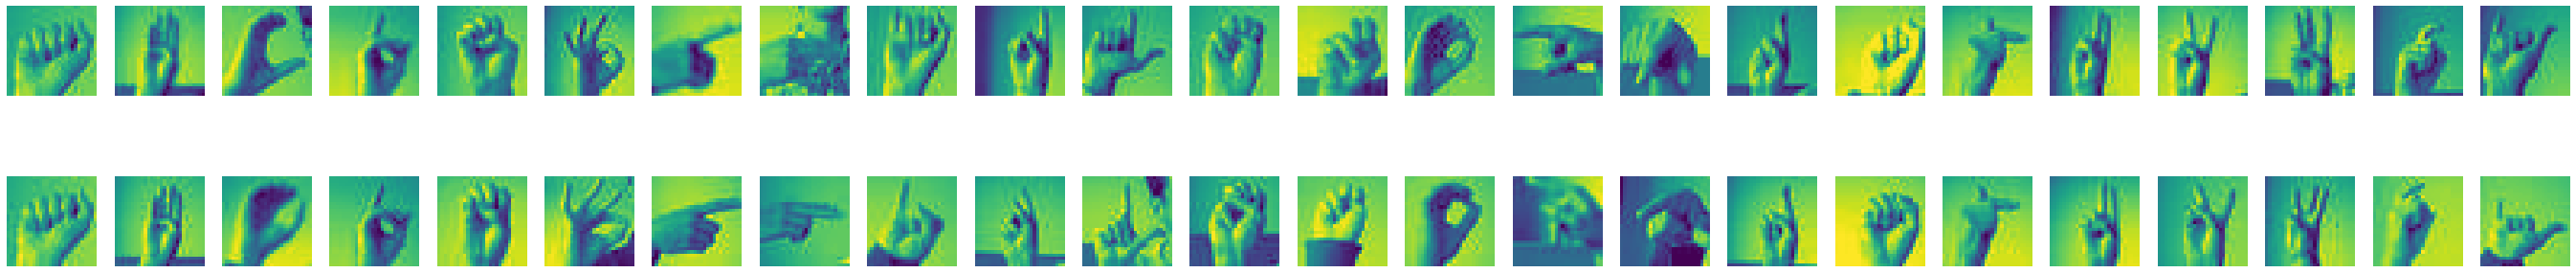

In [7]:
pic_index = 2
#random.seed(42)

# when we use random.shuffle, random.seed(42) doesn't have any effect to fix the randomness 
image_to_show = []

for letter_dir, letter_files in zip(alphabet_dir, alphabet_files):
    shuffled_letter_files = random.sample(letter_files, k=len(letter_files))
    letters_to_show = [os.path.join(letter_dir, fname) 
                       for fname in shuffled_letter_files[pic_index-2:pic_index]]
    #print(letters_to_show)
    image_to_show += letters_to_show
    
    
fig, ax = plt.subplots(nrows=2, ncols=24, figsize=(48,6))
    
for i, img_path in enumerate(image_to_show[:]):
    #print(img_path)
    img = mpimg.imread(img_path)
    ax[i%2, i//2].imshow(img)
    ax[i%2, i//2].axis('off')

    
plt.show()

In [8]:
img_example = mpimg.imread(image_to_show[0])
print(img_example.min(), img_example.max())
print(img_example.shape)

42 234
(28, 28)


In [9]:
TRAINING_DIR = "./hand-sign-images/Train/"
VALIDATION_DIR = "./hand-sign-images/Test/"

input_shape = (28, 28, 1)
num_classes = 24

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    # the dataset is already pre-processing, so we don't need this anymore
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(28,28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(28,28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 28x28 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    #-----
    # The second convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #-----
    # The third convolution
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #-----
    # The fourth convolution
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #-----
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.summary()

model.compile(
    loss = 'categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy'])

Found 27455 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               2769152   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                6168      
Total params: 2,841,752
Trainable p

In [10]:
time_callback = TimeHistory()
loss_callback = LossCallback()

history = model.fit(train_generator, 
                    epochs=1000, 
                    steps_per_epoch=20, 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=3,
                    callbacks=[time_callback, loss_callback]
                   )

model.save("hand-sign.h5")

Epoch 1/1000
20/20 [==============================] - 2s 97ms/step - loss: 3.2709 - accuracy: 0.0406 - val_loss: 3.1585 - val_accuracy: 0.0208
Epoch 2/1000
20/20 [==============================] - 1s 74ms/step - loss: 3.0871 - accuracy: 0.1172 - val_loss: 2.9801 - val_accuracy: 0.1667
Epoch 3/1000
20/20 [==============================] - 1s 68ms/step - loss: 2.8416 - accuracy: 0.2000 - val_loss: 2.6018 - val_accuracy: 0.2812
Epoch 4/1000
20/20 [==============================] - 1s 60ms/step - loss: 2.4873 - accuracy: 0.2594 - val_loss: 2.1554 - val_accuracy: 0.3542
Epoch 5/1000
20/20 [==============================] - 1s 71ms/step - loss: 2.1410 - accuracy: 0.3156 - val_loss: 2.1724 - val_accuracy: 0.3750
Epoch 6/1000
20/20 [==============================] - 2s 87ms/step - loss: 1.8679 - accuracy: 0.4094 - val_loss: 1.9232 - val_accuracy: 0.2812
Epoch 7/1000
20/20 [==============================] - 1s 67ms/step - loss: 1.6251 - accuracy: 0.5172 - val_loss: 1.8247 - val_accuracy: 0.4167

Epoch 58/1000
20/20 [==============================] - 2s 87ms/step - loss: 0.0284 - accuracy: 0.9937 - val_loss: 0.8719 - val_accuracy: 0.8229
Epoch 59/1000
20/20 [==============================] - 1s 72ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.5142 - val_accuracy: 0.7188
Epoch 60/1000
20/20 [==============================] - 1s 69ms/step - loss: 0.0232 - accuracy: 0.9906 - val_loss: 0.4926 - val_accuracy: 0.8854
Epoch 61/1000
20/20 [==============================] - 1s 73ms/step - loss: 0.0451 - accuracy: 0.9812 - val_loss: 0.7152 - val_accuracy: 0.7812
Epoch 62/1000
20/20 [==============================] - 2s 81ms/step - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.7717 - val_accuracy: 0.8646
Epoch 63/1000
20/20 [==============================] - 1s 54ms/step - loss: 0.0183 - accuracy: 0.9953 - val_loss: 1.0273 - val_accuracy: 0.7812
Epoch 64/1000
20/20 [==============================] - 1s 52ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.6903 - val_accuracy:

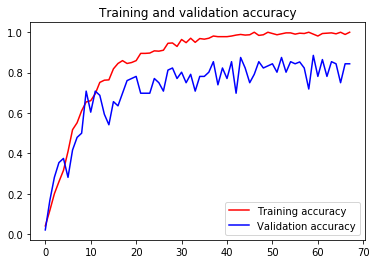

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.show();

In [12]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

total time fitting (approx.): 105.46 s


In [13]:
widgets.FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

FileUpload(value={}, description='Upload')

In [14]:
# import numpy as np
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
 
#     # predicting images
#     path = fn
#     img = image.load_img(path, target_size=(150, 150))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)

#     images = np.vstack([x])
#     classes = model.predict(images, batch_size=10)
#     classes_name = np.array(['paper', 'rock', 'scissors'])
#     #print(classes_name[np.array([int(round(p)) for p in classes[0]]) == 1])
#     print(fn, 'is', classes_name[np.array([int(round(p)) for p in classes[0]]) == 1][0])
#     print(classes)